# Project Part 3 - Prediction

This part of the project will be split into two parts. The first, undertaken in this notebook, will be a comparison of several classification algorithms tasked with predicting whether a seller in the marketplace will make a sale or not. The second part will be a prediction of the length of time it takes a seller's sale to sell, and this is found in the notebook time_to_sale_prediction.ipynb. 

This notebook is structured as follows:

    1. Data Wrangling, Calculating Accuracy and Comparisons
    2. Plots of the Model Evaluations
    3. Confusion Matrix
    4. Are we overfitting?
    5. Summary

# 1. Data Wrangling, Calculating Accuracy and Comparisons


First let's try and run a simple prediction on whether a seller who comes to market will complete a sale or not. We'll be using the data from our large run generated from marketplace_predictions.py and located in the /exploration/data/. As a reminder, the references for the different parameter sets is in the first section of the notebook data_exploration_2.ipynb. It would be useful to have this open in a seperate tab for quick referral.

Because we'll be dealing with large amounts of data, we'll first define a function to grab the data files. This is shown below and we'll use pandas to tidy up the data, rescale, and create extra features for z-scores and the exchange rate on the day advertised. We'll then evaluate the differences between Linear and Logistic Regression, Random Forest and K Nearest Neighbours in a matrix which will be output below as model_eval.

## WARNING: Takes a long time to run!

In [8]:
from sklearn.cross_validation import KFold,train_test_split,cross_val_score

def get_accuracy_2(df,alg,predictors):
    """
    Returns the accuracy of algorithm alg in predicting if a sale occurs or not
    for sellers in dataframe df, using predictors in the input list predictors.
    """
    X = df.reset_index()[predictors]
    Y = df.reset_index()["Sold"]
  
    # This time let's just let sklearn do the accuracy score for us...
  #  return cross_val_score(alg, X, Y, cv = KFold(len(X), n_folds=10,
  #                                         shuffle=True, random_state=4)).mean()
    
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)
    # Train the model, and evaluate it
    alg.fit(train_X, train_Y)
    y_pred = alg.predict(test_X)
    return accuracy_score(test_Y, np.round(y_pred))

def get_df(param_set, run):
    """
    Returns a wrangled dataframe for the input parameter set and run number
    """
    # Import the data for sold and unsold traders
    param_set = str(param_set) ;    run = str(run)
    sold = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_sold.csv')
    unsold = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_unsold.csv')
    
    ### Cast Day Tracker to list, trim data points within 'cutoff' days of simulation start/ends
    sold['Day Tracker'] = sold['Day Tracker'].apply(lambda x: x.split(','));
    sold = sold[sold['Day Advertised'] >=  8]; sold = sold[sold['Day Advertised'] <=  290]
    unsold['Day Tracker'] = unsold['Day Tracker'].apply(lambda x: x.split(','));
    unsold = unsold[unsold['Day Advertised'] >=  8]; unsold = unsold[unsold['Day Advertised'] <=  290]
    
    ## Create rates for each day for insertion into sold df
    rates = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_rates.csv')
    rate_dic = rates.to_dict()#['USD to EUR rate','USD sales','EUR sales']
    
    ### Get length of day tracker, save as new column - This is days spent in the market
    sold['Lens'] = sold['Day Tracker'].apply(lambda x : len(x));
    unsold['Lens'] = unsold['Day Tracker'].apply(lambda x : len(x));

    # Create a column for the interbank rate for the day advertised
    sold['Interbank'] = sold.apply(lambda row: rate_dic['USD to EUR rate'][row['Day Advertised']]\
                                   if(row['Currency']=='USD')\
                                   else 1.0/rate_dic['USD to EUR rate'][row['Day Advertised']],axis=1)
    unsold['Interbank'] = unsold.apply(lambda row: rate_dic['USD to EUR rate'][row['Day Advertised']]\
                                   if(row['Currency']=='USD')\
                                   else 1.0/rate_dic['USD to EUR rate'][row['Day Advertised']],axis=1)

    # Now do the z-scores
    sd_denom = 100.0 # standard deviation denominator, set in marketplace.py default value = 100 yields true SD = RATE/100
    sold.drop(['ID','Current Amount','Sale Tracker','Day Tracker',],inplace=True,axis=1);
    unsold.drop(['ID','Current Amount','Sale Tracker','Day Tracker',],inplace=True,axis=1);

    # Concatenate the sold and unsold DFs into one, 
    sold['Sold'] = 1; unsold['Sold'] = 0
    df = pd.concat([sold,unsold], ignore_index=True)
    
    df['z-score'] = df.apply(lambda row: (row['Rate Offered']-row['Interbank'] )/ (row['Interbank']/sd_denom ),axis=1)

    df['Currency'] = df.apply(lambda row: 0 if(row['Currency']=='EUR') else 1,axis=1)
    
    ## Rescale Features
    df['Initial Amount'] = df.apply(lambda row: (row['Initial Amount'])/np.max(df['Initial Amount']),axis=1)
    df['EUR sales'] =  df.apply(lambda row: np.log10(rate_dic['EUR sales'][row['Day Advertised']]),axis=1)
    df['USD sales'] =  df.apply(lambda row: np.log10(rate_dic['USD sales'][row['Day Advertised']]),axis=1)
    df['Day Advertised'] = df.apply(lambda row: (row['Day Advertised'])/np.max(df['Day Advertised']),axis=1)

    return df
    

algos = [LinearRegression(),LogisticRegression(),\
         RandomForestClassifier(n_estimators=5, max_depth=None,min_samples_split=1, random_state=0),\
         RandomForestClassifier(n_estimators=15, max_depth=None,min_samples_split=1, random_state=0),\
         KNeighborsClassifier(n_neighbors=5),\
         KNeighborsClassifier(n_neighbors=15)]

predictors = ['Currency', 'Initial Amount', 'Rate Offered',\
                  'z-score',\
                'Interbank','Day Advertised',\
#                  'EUR sales','USD sales'\
                ]

cols = ['LinReg','LogReg','RF5','RF10','KNN5','KNN10']

param_sets = range(1,8)
runs = range(0,5)

model_eval =  pd.DataFrame(index=None, columns=cols).fillna(0)

for alg, col in zip(algos,cols):
        print 'Algo = ', col
        for param_set in param_sets:
            avg = [0]*len(runs)
            for run in runs:
                print 'Evaluating run ', run, ' of pset ', param_set
                df = get_df(param_set,run)
                acc = get_accuracy_2(df, alg, predictors)
                avg[run] = acc
            mean = np.mean(np.array(avg))
            model_eval.ix[str(param_set),col] = mean
            print mean #, avg
print model_eval

#        print gamma, C ,get_accuracy(df, alg, predictors)

Algo =  LinReg
Evaluating run  0  of pset  1
Evaluating run  1  of pset  1
Evaluating run  2  of pset  1
Evaluating run  3  of pset  1
Evaluating run  4  of pset  1
0.97345132444
Evaluating run  0  of pset  2
Evaluating run  1  of pset  2
Evaluating run  2  of pset  2
Evaluating run  3  of pset  2
Evaluating run  4  of pset  2
0.834960403704
Evaluating run  0  of pset  3
Evaluating run  1  of pset  3
Evaluating run  2  of pset  3
Evaluating run  3  of pset  3
Evaluating run  4  of pset  3
0.838926265315
Evaluating run  0  of pset  4
Evaluating run  1  of pset  4
Evaluating run  2  of pset  4
Evaluating run  3  of pset  4
Evaluating run  4  of pset  4
0.9748380023
Evaluating run  0  of pset  5
Evaluating run  1  of pset  5
Evaluating run  2  of pset  5
Evaluating run  3  of pset  5
Evaluating run  4  of pset  5
0.825642539281
Evaluating run  0  of pset  6
Evaluating run  1  of pset  6
Evaluating run  2  of pset  6
Evaluating run  3  of pset  6
Evaluating run  4  of pset  6
0.83513734603

In [9]:
####### SAVE TABLE #######
model_eval.to_csv('classification_prediction_table.csv')

# 2. Plots of the Model Evaluations

We can plot the evaluation matrix to get it in a more visually appealing and useful form. Below is a discrete heat map and then a bar chart to allow us to more easily compare the various models.

      LinReg     LogReg        RF5       RF10       KNN5      KNN10
1  0.9734513  0.9993947          1          1  0.9983441  0.9984508
2  0.8349604  0.8605234  0.9874668  0.9892091  0.9017827  0.8996499
3  0.8389263  0.8397075  0.9901506  0.9927106  0.8951693  0.8789172
4   0.974838  0.9997087  0.9999838  0.9999838  0.9980744  0.9982686
5  0.8256425  0.8225827  0.9877637  0.9899486  0.9040488   0.899468
6  0.8351373  0.8339421  0.9908214   0.994021  0.9014736  0.8825995
7  0.8013611  0.8072192  0.9920199  0.9941371  0.8943727  0.8736004


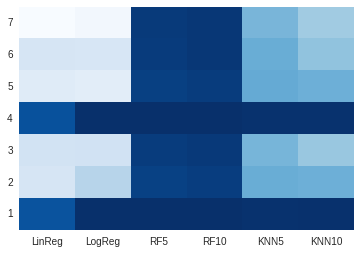

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
print model_eval
plt.pcolor(model_eval,cmap=plt.cm.Blues)
plt.yticks(np.arange(0.5, len(model_eval.index), 1), model_eval.index)
plt.xticks(np.arange(0.5, len(model_eval.columns), 1), model_eval.columns)
plt.show()

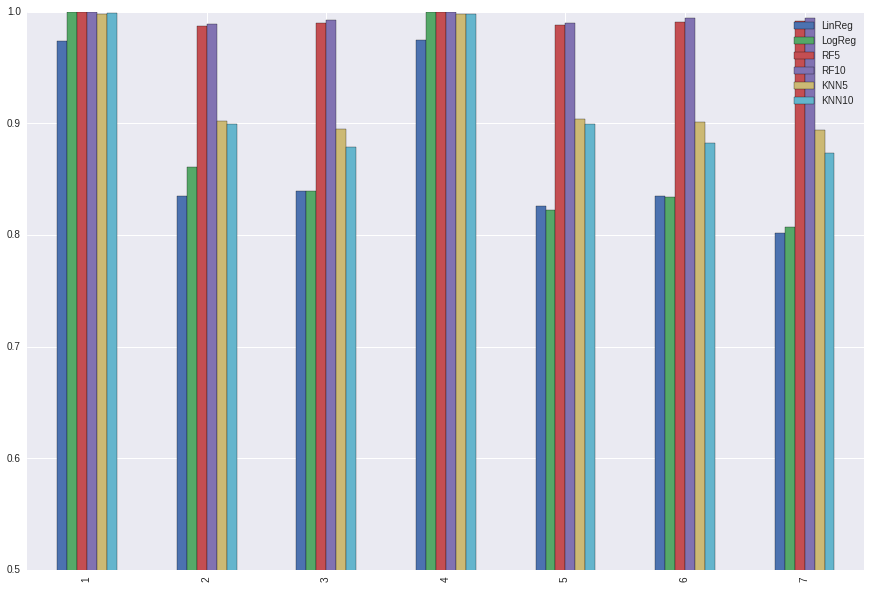

In [11]:
model_eval.plot(kind='bar',ylim=([0.5,1]),figsize=(15,10))

# 3. Confusion Matrix

We can check how well the classification works using a confusion matrix - this will give us a test on the number of false positives/false negatives that our prediction algorithm gives. This is useful as we know from our data exploration that there will be many more sellers than non-sellers, so if our algorithms are not very accurate in predicting non-sellers this could be missed by just taking the face value of the accuracy score above. The code default below computes a confusion matrix using Random Forest with 15 estimators on parameter set 7.

In [1]:
from sklearn.cross_validation import train_test_split
import matplotlib.pylab as plt
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
import pandas as pd ; import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

%matplotlib inline  

def get_df(param_set, run):
    param_set = str(param_set) ;    run = str(run)
    sold = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_sold.csv')
    unsold = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_unsold.csv')
    
    ### Cast Day Tracker to list, trim data points within 'cutoff' days of simulation start/ends
    sold['Day Tracker'] = sold['Day Tracker'].apply(lambda x: x.split(','));
    sold = sold[sold['Day Advertised'] >=  8]; sold = sold[sold['Day Advertised'] <=  290]
    unsold['Day Tracker'] = unsold['Day Tracker'].apply(lambda x: x.split(','));
    unsold = unsold[unsold['Day Advertised'] >=  8]; unsold = unsold[unsold['Day Advertised'] <=  290]
    ## Create rates for each day for insertion into sold df
    rates = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_rates.csv')
    rate_dic = rates.to_dict()#['USD to EUR rate','USD sales','EUR sales']
    ### Get length of day tracker, save as new column - This is days spent in the market
    sold['Lens'] = sold['Day Tracker'].apply(lambda x : len(x));
    unsold['Lens'] = unsold['Day Tracker'].apply(lambda x : len(x));

    # Create a column for the interbank rate for the day advertised
    sold['Interbank'] = sold.apply(lambda row: rate_dic['USD to EUR rate'][row['Day Advertised']]\
                                   if(row['Currency']=='USD')\
                                   else 1.0/rate_dic['USD to EUR rate'][row['Day Advertised']],axis=1)
    unsold['Interbank'] = unsold.apply(lambda row: rate_dic['USD to EUR rate'][row['Day Advertised']]\
                                   if(row['Currency']=='USD')\
                                   else 1.0/rate_dic['USD to EUR rate'][row['Day Advertised']],axis=1)

    # Now do the z-scores
    sd_denom = 100.0 # standard deviation denominator, set in marketplace.py default value = 100 yields true SD = RATE/100
    sold.drop(['ID','Current Amount','Sale Tracker','Day Tracker',],inplace=True,axis=1);
    unsold.drop(['ID','Current Amount','Sale Tracker','Day Tracker',],inplace=True,axis=1);

    sold['Sold'] = 1; unsold['Sold'] = 0
    df = pd.concat([sold,unsold], ignore_index=True)
    
    df['z-score'] = df.apply(lambda row: (row['Rate Offered']-row['Interbank'] )/ (row['Interbank']/sd_denom ),axis=1)

    df['Currency'] = df.apply(lambda row: 0 if(row['Currency']=='EUR') else 1,axis=1)
    
    ## Rescale Features
    df['Initial Amount'] = df.apply(lambda row: (row['Initial Amount'])/np.max(df['Initial Amount']),axis=1)
    df['EUR sales'] =  df.apply(lambda row: np.log10(rate_dic['EUR sales'][row['Day Advertised']]),axis=1)
    df['USD sales'] =  df.apply(lambda row: np.log10(rate_dic['USD sales'][row['Day Advertised']]),axis=1)
    df['Day Advertised'] = df.apply(lambda row: (row['Day Advertised'])/np.max(df['Day Advertised']),axis=1)

    return df
    
param_set = 7
run = 1

df  = get_df(param_set,run)

predictors = ['Currency', 'Initial Amount', 'Rate Offered',\
                  'z-score',\
                'Interbank','Day Advertised',\
#                  'EUR sales','USD sales'\
                ]

X = df.reset_index()[predictors]
Y = df.reset_index()["Sold"]

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

# Train the model, and evaluate it
alg = RandomForestRegressor(n_estimators=15)
#alg = KNeighborsClassifier(n_neighbors=15)
alg.fit(train_X, train_Y)
y_pred = alg.predict(test_X)
print accuracy_score(test_Y, np.round(y_pred))
#test_Y = pd.Series(test_Y, name='Actual')
#y_pred = pd.Series( np.round(y_pred), name='Predicted')
# Make normalised confusion matrix
cm = pd.crosstab(test_Y, np.round(y_pred), rownames=['Actual'], colnames=['Predicted'], margins=True)
print cm
    

0.994125805662
Predicted   0.0   1.0    All
Actual                      
0          2842    45   2887
1            27  9343   9370
All        2869  9388  12257


It seems our classification algorithm does a pretty good job of identifying sellers and non-sellers correctly, with very few misclassifications. However, an accuracy of 99.4% seems extremely high and should be viewed with suspicion - we are probably overfitting our prediction algorithm to the available data. 

# 4. Are we overfitting?

Basically, yes. While it does seem probable that the underlying mathematical rules of the marketplace may make the behaviour of some parameter sets easy to predict - for example in the constant exchange rate model (set 1) there is very little randomness in the system. Parameter set 7 uses the GBM model with a varying number of buyers and sellers on each market iteration, as well as different currency amounts used. Therefore we shouldn't expect to get such a good prediction rate, and so we are most likely overfitting, especially with the Random Forest model (see plots in previous sections - this algorithm scores consistently over 95% accuracy).

Below is a short piece of code using the Random Forest algorithm, however the algorithm has been tweaked to correct for overfitting. Several things can be done to correct for this:
    - increase the number of trees (n_estimators)
    - reduce the number of features assigned to each tree (max_features)
    - reduce the max depth of the trees, reducing the tree complexity (max_depth)
    - increasing minimum number of samples required to split a node (min_samples_leaf)

In [15]:
# Prepare data for cell below
param_set = 7 ; run = 1 ; df  = get_df(param_set,run)
predictors = ['Currency', 'Initial Amount', 'Rate Offered', 'z-score', 'Interbank','Day Advertised']
X = df.reset_index()[predictors] ; Y = df.reset_index()["Sold"]

In [33]:
# Test for overfitting...
for md in range(1,1000,100):
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33)
    # Train the model, and evaluate it
    alg = RandomForestRegressor(n_estimators=50,
                                max_features = 3,
                                max_depth = 5,
                                min_samples_leaf = md)
    alg.fit(train_X, train_Y)
    y_pred = alg.predict(test_X)
    print md , accuracy_score(test_Y, np.round(y_pred))

1 0.860455916531
101 0.867527073135
201 0.847994857341
301 0.846363051971
401 0.851159570786
501 0.843544479058
601 0.837511744054
701 0.834693171142
801 0.825396825397
901 0.831083419868


By experimenting with these various inputs a more reasonable prediction score can be obtained. A score around 80%-90% is considered to be optimal.

# 5. Summary

In this notebook we have compared and contrasted several machine learning algorithms on the task of predicting whether a seller in our simulated marketplace will sell or not. We also looked at the phenomenon of overfitting of the Random Forest algorithm and steps taken to resolve this issue.